# UNav Mapping - Feature Extraction Verification

This notebook provides verification and visualization for extracted features in the UNav Mapping pipeline.

It supports checking both:
- Global descriptors (e.g., MixVPR, DinoV2Salad)
- Local features (e.g., SuperPoint + LightGlue)

---

## 📍 Recommended Initialization

Use centralized project-level configurations for consistency:

```python
DATA_TEMP_ROOT = '/mnt/data/UNav-IO/temp'
DATA_FINAL_ROOT = '/mnt/data/UNav-IO/data'

PLACEHOLDER = 'New_York_City'
BUILDING = 'LightHouse'
FLOOR = '3_floor'

from unav_mapping.config import UNavMappingConfig

config = UNavMappingConfig(
    data_temp_root=DATA_TEMP_ROOT,
    data_final_root=DATA_FINAL_ROOT,
    place=PLACEHOLDER,
    building=BUILDING,
    floor=FLOOR,
    global_descriptor_model='DinoV2Salad',
    local_feature_model='superpoint+lightglue'
)
```

---

## ✅ Notebook Content

1. Extract features using `feature_extractor.py`.
2. Validate the existence and quality of global descriptors.
3. Validate local features and keypoints.
4. Visualize keypoints on perspective images.

---

## 💡 Note

All features and models are configurable via `UNavMappingConfig`.  
This notebook is designed for easy validation after feature extraction is completed.

---


In [9]:
DATA_TEMP_ROOT = '/mnt/data/UNav-IO/temp'
DATA_FINAL_ROOT = '/mnt/data/UNav-IO/data'

PLACEHOLDER = 'New_York_City'
BUILDING = 'LightHouse'
FLOOR = '4_floor'

FEATURE_MODEL = 'DinoV2Salad'

import os
import h5py
from visualization_tools.mapping_visualization_tools import visualize_point_cloud_views, plot_camera_trajectory_xz, visualize_random_matches, show_sample_images_with_pose, visualize_local_keypoints, render_colmap_point_cloud_views
from config import UNavConfig

config = UNavConfig(data_temp_root=DATA_TEMP_ROOT,
                 data_final_root=DATA_FINAL_ROOT,
                 mapping_place=PLACEHOLDER,
                 mapping_building=BUILDING,
                 mapping_floor=FLOOR,
                 global_descriptor_model=FEATURE_MODEL)

config = config.mapping_config

[✓] YAML written to: /mnt/data/UNav-IO/temp/equirectangular.yaml.


[INFO] Points before filtering: 1982907, after: 1982907 (100.0%)


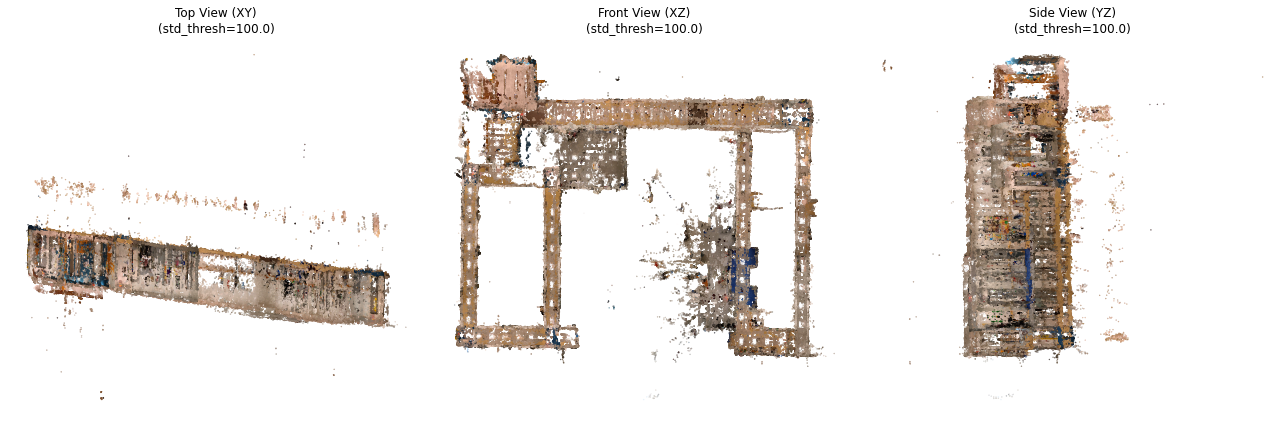

In [10]:
pc_path = os.path.join(config.data_temp_root, config.place, config.building, config.floor, "stella_vslam_dense", "output_cloud.ply")

visualize_point_cloud_views(pc_path, std_threshold=100.0)

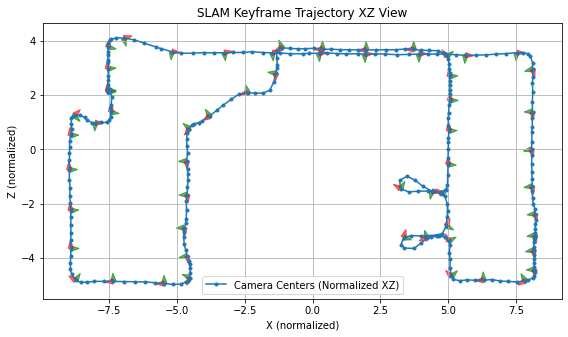

In [11]:
plot_camera_trajectory_xz(
    config.slicer_config["trajectory_file"],
    title="SLAM Keyframe Trajectory XZ View",
    show_axis=True,
)


[INFO] Total images found with pose: 6408


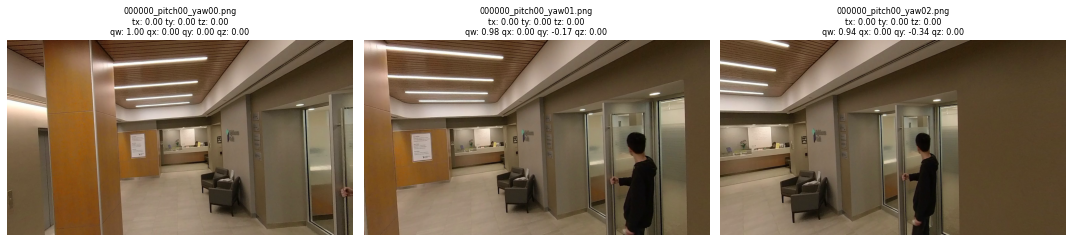

In [4]:
show_sample_images_with_pose(
    image_dir=config.slicer_config["output_perspective_dir"],
    image_file=config.colmap_config["image_file"],
    num_images=3
)

In [5]:
# verify global descriptor
global_feat_path = os.path.join(
    config.feature_extraction_config["output_feature_dir"],
    f"global_features_{config.feature_extraction_config['global_descriptor_model']}.h5"
)

print(f"[INFO] Checking global features: {global_feat_path}")
with h5py.File(global_feat_path, 'r') as h5_file:
    print(f"[INFO] Total images with global descriptor: {len(h5_file.keys())}")
    sample_img = list(h5_file.keys())[0]
    descriptor = h5_file[sample_img][:]
    print(f"[Sample Image] {sample_img}")
    print(f"[Descriptor Shape] {descriptor.shape}")
    print(f"[Descriptor Mean] {descriptor.mean():.4f}")
    print(f"[Descriptor Std] {descriptor.std():.4f}")

[INFO] Checking global features: /mnt/data/UNav-IO/data/New_York_City/LightHouse/6_floor/features/global_features_DinoV2Salad.h5
[INFO] Total images with global descriptor: 6408
[Sample Image] 000000_pitch00_yaw00.png
[Descriptor Shape] (8448,)
[Descriptor Mean] -0.0001
[Descriptor Std] 0.0109


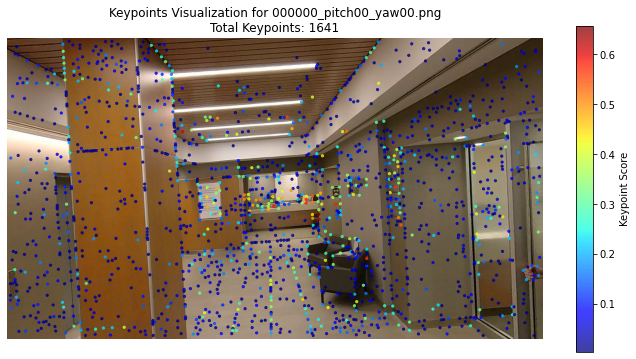

In [6]:
# verify local descriptor
visualize_local_keypoints(
    img_name=sample_img,
    image_dir=config.feature_extraction_config["input_perspective_dir"],
    local_feature_file=config.feature_extraction_config['local_feat_save_path']
)

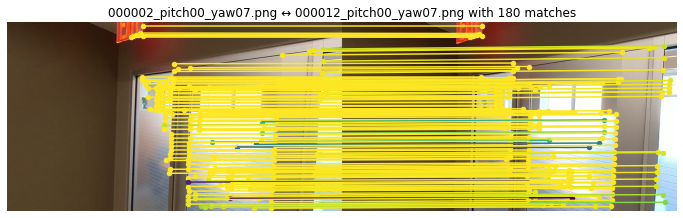

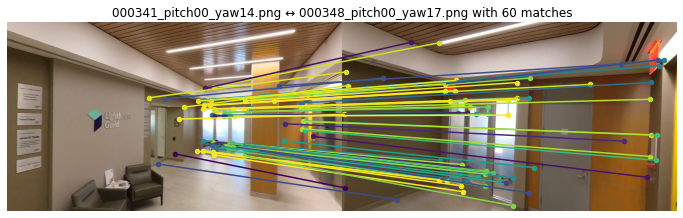

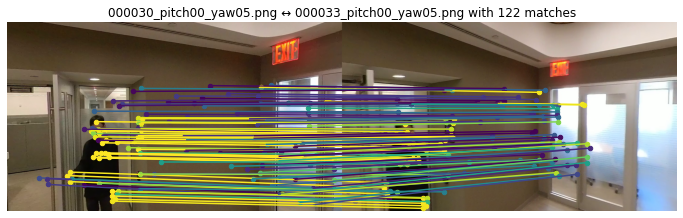

In [7]:
visualize_random_matches(
    local_feature_file=config.feature_extraction_config["local_feat_save_path"],
    matches_file=config.colmap_config["match_file"],
    image_dir=config.slicer_config["output_perspective_dir"],
    num_pairs=3,
    colormap='viridis'
)


[INFO] Total images: 6408
[INFO] Total 3D points before filtering: 127959
[INFO] 3D points after outlier removal: 109707


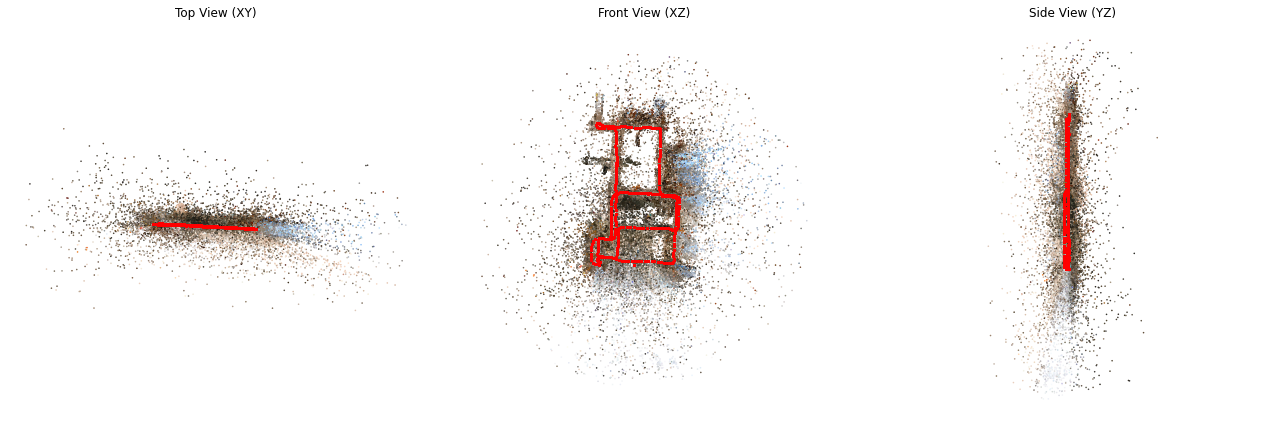

In [8]:
model_dir = os.path.join(
    config.data_final_root,
    config.place,
    config.building,
    config.floor,
    "colmap_map"
)

render_colmap_point_cloud_views(model_dir, ext=".bin")
